In [1]:
import rasterio
import tqdm
import leafmap
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import concurrent.futures
from mpire import WorkerPool
from skimage.restoration import denoise_tv_bregman
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.var import VAR

# Load Burst and Denoise

In [2]:
BURST_ID = 'T126-269585-IW2'

In [3]:
df_rtc = pd.read_json('../4_rtc_organization/rtc_s1_table.json.zip')
df_rtc.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
1,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
2,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
3,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
4,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


In [4]:
df_rtc_ts = df_rtc[df_rtc.jpl_burst_id == BURST_ID].reset_index(drop=True)

In [5]:
def open_one(path: str) -> tuple:
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile
    X = np.clip(X, 0, 1)
    return (X), p

def normalize_pol_ratio(img: np.ndarray, max_factor: float = 4.):
    vmax = max_factor
    vmin = 1e-7
    
    img_out = img.copy()
    img_out = np.clip(img_out, vmin, vmax)

    img_out = (img_out - vmin) / (vmax - vmin)    
    return img_out
    

def despeckle_one(X: np.ndarray, reg_param=2, noise_floor_db = -22) -> np.ndarray:
    X_c = np.clip(X, 1e-7, 1)
    X_db = 10 * np.log10(X_c, out=np.full(X_c.shape, np.nan), where=(~np.isnan(X_c)))
    X_db[np.isnan(X_c)] = noise_floor_db
    X_db_dspkl = denoise_tv_bregman(X_db, weight=.2, isotropic=True, eps=1e-3)
    X_dspkl = np.power(10, X_db_dspkl / 10.)
    X_dspkl[np.isnan(X)] = np.nan
    X_dspkl = np.clip(X_dspkl, 0, 1)
    return X_dspkl

In [6]:
df_rtc_ts.shape

(67, 8)

In [7]:
I = 5
K = 30

with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    data = list(tqdm(executor.map(open_one, df_rtc_ts.rtc_s1_vv_url[I:I + K]), total=K))
arrs_vv, profiles = zip(*data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.15it/s]


In [8]:
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    data = list(tqdm(executor.map(open_one, df_rtc_ts.rtc_s1_vh_url[I:I + K]), total=K))
arrs_vh, _ = zip(*data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.07it/s]


In [9]:
with WorkerPool(n_jobs=10, use_dill=True) as pool:
    arrs_vv_d = pool.map(despeckle_one,
                         arrs_vv, 
                         progress_bar=True, 
                         progress_bar_style='notebook', 
                         concatenate_numpy_output=False)

  0%|                                                                                                         …

In [10]:
with WorkerPool(n_jobs=10, use_dill=True) as pool:
    arrs_vh_d = pool.map(despeckle_one, 
                         arrs_vh, 
                         progress_bar=True, 
                         progress_bar_style='notebook', 
                         concatenate_numpy_output=False)

  0%|                                                                                                         …

## Patch Read

In [11]:
df_patch_all = pd.read_json('../6_torch_dataset/dist_s1_patch_lut.json.zip')
df_patch_all.head()

,x_start,x_stop,y_start,y_stop,epsg,jpl_burst_id
0,2960,3184,200,424,32614,T005-008688-IW2
1,2980,3204,200,424,32614,T005-008688-IW2
2,3000,3224,200,424,32614,T005-008688-IW2
3,3020,3244,200,424,32614,T005-008688-IW2
4,2860,3084,220,444,32614,T005-008688-IW2


In [12]:
df_patches = df_patch_all[df_patch_all.jpl_burst_id == BURST_ID].reset_index(drop=True)
df_patches.head()

,x_start,x_stop,y_start,y_stop,epsg,jpl_burst_id
0,320,544,160,384,32723,T126-269585-IW2
1,280,504,180,404,32723,T126-269585-IW2
2,300,524,180,404,32723,T126-269585-IW2
3,320,544,180,404,32723,T126-269585-IW2
4,340,564,180,404,32723,T126-269585-IW2


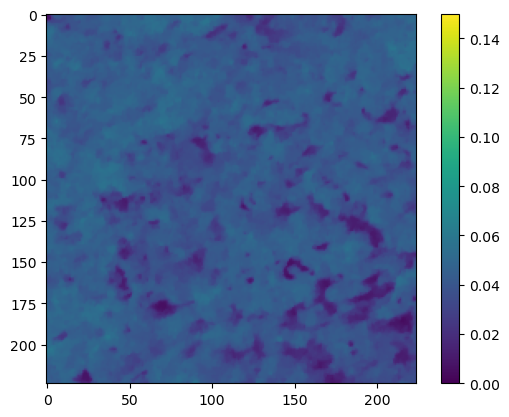

In [13]:
J = 2000
patches = df_patches.to_dict('records')
r = patches[J]

sy = np.s_[r['y_start']: r['y_stop']]
sx = np.s_[r['x_start']: r['x_stop']]

plt.imshow(arrs_vh_d[0][sy, sx], vmin=0, vmax=.15)
plt.colorbar()

In [180]:
# patch_ts = []
# for X in arrs_vh_d:
#     plt.figure()
#     patch_ts.append(X[sy, sx].copy())
#     plt.imshow(X[sy, sx], vmin=0, vmax=.15)
#     plt.show()
#     plt.close() 

# ZScore / Mahalanobis 1d

Notes:

- We are interested in using a stack radar backscatter images to see if we can observe changes in the next observed SAR image. We use the terminology "pre-images" and "post-image". The "pre-images" are the images that comprise our "stack" and are used to determine the qualitative statistics of the observations. The "post-image" is the image that is analyzed next.
- The 1d mahalanobis distance is defined as $| x - \mu| / \sigma$. Here $\mu$ and $\sigma$ are per-pixel statistics collected fromt the pre-images (here, we actually a 3 x 3 patch around each pixel).
- We made some empirical modifications. Let's define a "stable" point as those points with small $\sigma$ through time (let's assume small here is $< .01$). Such points can have large Mahalanobis distance in that even a small deviation from $\mu$ can lead to a 100x (or more) increase due to the $\sigma$ denominator. To remedy this, we replace $\sigma$ with $\widehat \sigma:= \max(\sigma, .01)$. This empirical floor is selected as the dynamic range of backscatter is between $[0, 1]$. Moreover, and most importantly, any deviation between $\mu$ and the post-image that's *smaller* than $.01$ in $\gamma$ is likely spurious when $\sigma$ is small.
- All the statistics are spatio-temporal and are collected via a $3 \times 3$ patch and through all available time.

In [31]:
from astropy.convolution import convolve

def get_spatiotemporal_mu(arrs: list[np.ndarray],
                          kernel_width=3,
                          kernel_height=3,
                          normalize_means: bool = True) -> np.ndarray:
    k_shape = (kernel_height, kernel_width)
    kernel = np.ones(k_shape, dtype=np.float32) / np.prod(k_shape)
    
    arrs_n = arrs
    if normalize_means:
        mu_t = [np.nanmean(arr) for arr in arrs]
        arrs_n = [arr - mu_t[k] + mu_t[0] for (k, arr) in enumerate(arrs)]
    
    mus_spatial = [convolve(arr, 
                            kernel, 
                            boundary="extend", 
                            nan_treatment='interpolate')
                   for arr in arrs_n]
    mu = sum(mus_spatial) / len(arrs)
    return mu

def get_spatiotemporal_std(arrs: list[np.ndarray],
                           mu_st=None,
                           kernel_width=3,
                           kernel_height=3,
                           normalize_means: bool = True) -> np.ndarray:
    if mu_st is None:
        mu_st = get_spatiotemporal_mu(arrs, 
                                      kernel_width=kernel_width, 
                                      kernel_height=kernel_height)
    
    k_shape = (kernel_height, kernel_width)
    kernel = np.ones(k_shape, dtype=np.float32) / np.prod(k_shape)
    
    arrs_n = arrs
    if normalize_means:
        mu_t = [np.nanmean(arr) for arr in arrs]
        arrs_n = [arr - mu_t[k] + mu_t[0] for (k, arr) in enumerate(arrs)]

    var_s = [convolve((arr - mu_st)**2, 
                     kernel, 
                     boundary="extend", 
                     nan_treatment='interpolate')
            for arr in arrs_n]
    var_st = sum(var_s) / len(arrs)
    sigma = np.sqrt(var_st)
    return sigma

def get_zscore(arrs: list[np.ndarray],
                post_arr: np.ndarray,
                min_sigma: float = .01,
                kernel_width=3,
                kernel_height=3,
                normalize_means: bool = True) -> tuple[np.ndarray]:
                
    
    mu_st = get_spatiotemporal_mu(arrs, 
                               kernel_width=kernel_width, 
                               kernel_height=kernel_height,
                               normalize_means=normalize_means)
    std_st = get_spatiotemporal_std(arrs, 
                                    mu_st=mu_st, 
                                    kernel_width=kernel_width, 
                                    kernel_height=kernel_height,
                                    normalize_means=normalize_means)

    std_floor = np.maximum(std_st, min_sigma)
    if normalize_means:
        post_arr = post_arr - np.nanmean(post_arr) + np.nanmean(arrs[0])
    z_score = (post_arr - mu_st) / std_floor
    return mu_st, std_floor, z_score

In [181]:
ts = arrs_vv_d[:]

P = 0
Q = 10
R = 0
pre = ts[P: P+ Q]
post = ts[Q + R]

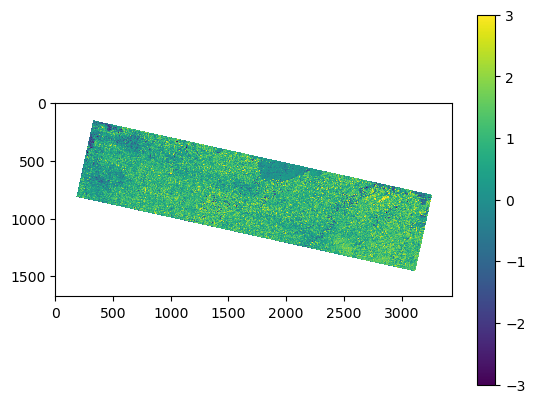

In [182]:
mu, std, z_score = get_zscore(pre, 
                              post, 
                              normalize_means=False)

plt.imshow(z_score, vmin=-3, vmax=3, interpolation='none')
plt.colorbar()

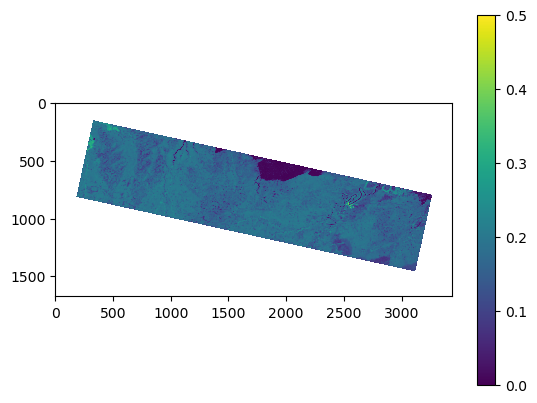

In [183]:
plt.imshow(mu, vmin=0, vmax=.5, interpolation='none')
plt.colorbar()

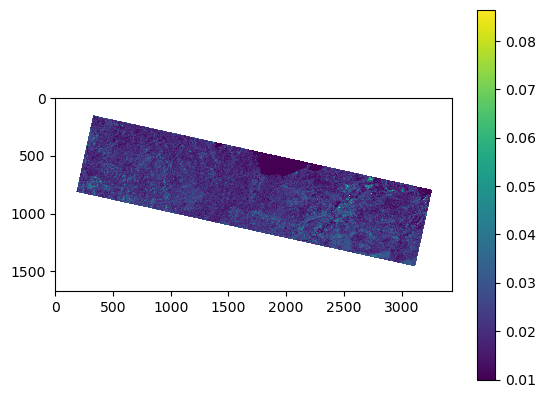

In [184]:
plt.imshow(std, interpolation='none')
plt.colorbar()

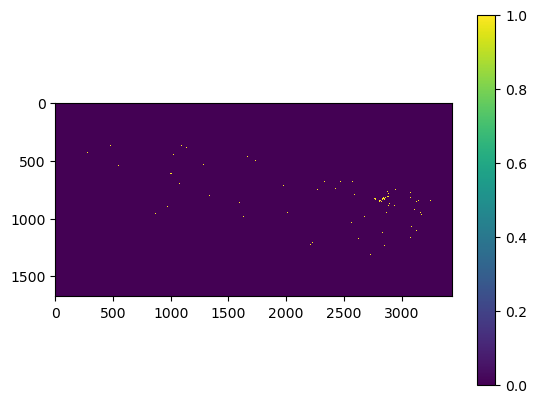

In [185]:
plt.imshow(np.abs(z_score) > 3, vmin=0, vmax=1, interpolation='none')
plt.colorbar()

In [186]:
sxx = np.s_[1000:2_000]
syy = np.s_[500: 1000]

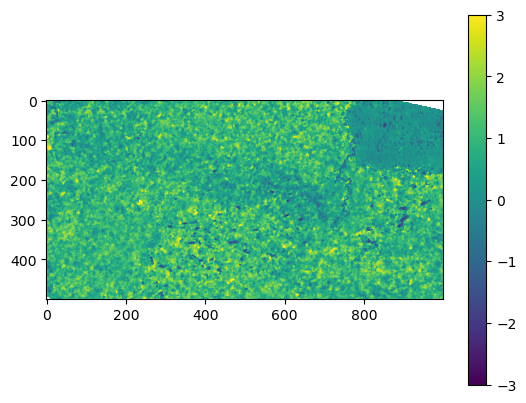

In [187]:
plt.imshow(z_score[syy, sxx], vmin=-3, vmax=3)
plt.colorbar()

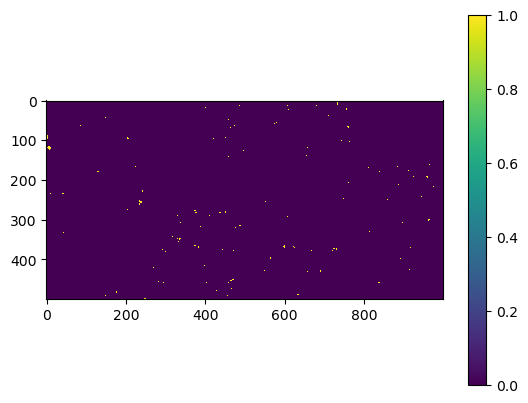

In [188]:
plt.imshow(np.abs(z_score[syy, sxx]) > 3, vmin=0, vmax=1, interpolation='none')
plt.colorbar()